# 폐렴아 기다려라!

**[문제개요]**  
정상/폐렴 환자들의 X-ray 사진 데이터가 주어졌을 때, 데이터 전처리 및 CNN/ResNet-18 구조의 이진 분류(폐렴 여부 판단) 모델을 구현하고 실험하기

**[평가기준]**  
⭐️ 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.	모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.  
⭐️ 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.	regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.  
⭐️ ResNet 모델을 구현 하였다.  Resnet 의 Residual block을 구현하고 학습의 경우 1에폭만 진행하여도 인정

---
### 📝 Overview
1. **Import libraries & packages** : 각종 라이브러리, 패키지 불러오기
2. **Define constants, useful variables & methods** : 자주 쓰이는 변수, 함수 사전 정의
3. **Prepare data** : 학습 데이터 준비 (test&val 재분배, 이미지 크기 및 형식 변환, augmentation 등)
4. **Construct CNN model** : CNN 모델 구현 (기존 노드 참조)
5. **Construct ResNet-18 model** : ResNet-18 모델 구현 (Kaggle 제공 코드 참조)
6. **Prepare experiments** : 실험을 위한 변수 설정 및 실험 파이프라인 설계
7. **Experimental results** : 실험 수행 및 결과 분석
- **Research note** : 연구노트 (회고록)
- **references** : 퀘스트 수행을 위한 참조 논문 및 사이트

---
## 🩻 Import libraries & packages

In [1]:
# import useful tools
import random    # generate random numbers
import math      # mathematical compuation

import os        # get environment variables
import re        # regular expression (text pattern)
import warnings  # ignore warnings
warnings.filterwarnings(action='ignore')


# import data tools
import numpy as np


# import visualization tools
import matplotlib.pyplot as plt


# import DL tools
import tensorflow as tf

---
## 🩻 Define constants, usful variables & methods

In [2]:
# configuration variable to load data in high speed
AUTOTUNE = tf.data.experimental.AUTOTUNE


# pixel size of image data
IMG_SIZE = [180, 180]


# image data path
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'
    # "*" indications all directories and files


# type number of training models
CNN = 1
RESNET = 18


# hyper-parameters for model training
BATCH_SIZE = 16
EPOCHS = 10

In [3]:
# constant, methods to print dividers

DIVIDER_LEN = 80

def print_single_divider():
    print("-" * DIVIDER_LEN)
    
def print_double_divider():
    print("=" * DIVIDER_LEN)    

---
## 🩻 Prepare data

### 1. Get image data file names

**1-1. Get image data file names**

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)

In [5]:
# check the number of image data fils

total_filenames_cnt = len(train_filenames) + len(test_filenames) + len(val_filenames)
print("Total", total_filenames_cnt, "image data files are found!")

print_single_divider()
print(">>> Total image data files      : ", total_filenames_cnt) 

print_single_divider()
print(">>> Training image data files   : ", len(train_filenames))
print("    >>> NORMAL case             : ", len([filename for filename in train_filenames if "NORMAL" in filename]))
print("    >>> PNEUMONIA               : ", len([filename for filename in train_filenames if "PNEUMONIA" in filename]))

print_single_divider()
print(">>> Validation image data files : ", len(val_filenames))
print("    >>> NORMAL case             : ", len([filename for filename in val_filenames if "NORMAL" in filename]))
print("    >>> PNEUMONIA               : ", len([filename for filename in val_filenames if "PNEUMONIA" in filename]))

print_single_divider()
print(">>> Test image data files       : ", len(test_filenames))
print("    >>> NORMAL case             : ", len([filename for filename in test_filenames if "NORMAL" in filename]))
print("    >>> PNEUMONIA               : ", len([filename for filename in test_filenames if "PNEUMONIA" in filename]))

print_single_divider()

Total 5856 image data files are found!
--------------------------------------------------------------------------------
>>> Total image data files      :  5856
--------------------------------------------------------------------------------
>>> Training image data files   :  5216
    >>> NORMAL case             :  1341
    >>> PNEUMONIA               :  3875
--------------------------------------------------------------------------------
>>> Validation image data files :  16
    >>> NORMAL case             :  8
    >>> PNEUMONIA               :  8
--------------------------------------------------------------------------------
>>> Test image data files       :  624
    >>> NORMAL case             :  234
    >>> PNEUMONIA               :  390
--------------------------------------------------------------------------------


⚠️ 전체 이미지 데이터 수에 비해 validation 데이터가 적다!

**1-2. Split training & validation data**  
💡 training 데이터의 일부를 validation 데이터로 사용하도록 데이터 비율 재분배

In [6]:
# collect all training and validation data in "filenames" variable
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# split image data in "filenames" at the rate of (training:validation) = (8:2)
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

In [7]:
# re-check the number of image data files

total_filenames_cnt = len(train_filenames) + len(test_filenames) + len(val_filenames)
print("Total", total_filenames_cnt, "image data files are found!")

print_single_divider()
print(">>> Total image data files      : ", total_filenames_cnt) 

print_single_divider()
print(">>> Training image data files   : ", len(train_filenames))
print("    >>> NORMAL case             : ", len([filename for filename in train_filenames if "NORMAL" in filename]))
print("    >>> PNEUMONIA               : ", len([filename for filename in train_filenames if "PNEUMONIA" in filename]))

print_single_divider()
print(">>> Validation image data files : ", len(val_filenames))
print("    >>> NORMAL case             : ", len([filename for filename in val_filenames if "NORMAL" in filename]))
print("    >>> PNEUMONIA               : ", len([filename for filename in val_filenames if "PNEUMONIA" in filename]))

print_single_divider()
print(">>> Test image data files       : ", len(test_filenames))
print("    >>> NORMAL case             : ", len([filename for filename in test_filenames if "NORMAL" in filename]))
print("    >>> PNEUMONIA               : ", len([filename for filename in test_filenames if "PNEUMONIA" in filename]))

print_single_divider()

Total 5856 image data files are found!
--------------------------------------------------------------------------------
>>> Total image data files      :  5856
--------------------------------------------------------------------------------
>>> Training image data files   :  4185
    >>> NORMAL case             :  1070
    >>> PNEUMONIA               :  3115
--------------------------------------------------------------------------------
>>> Validation image data files :  1047
    >>> NORMAL case             :  279
    >>> PNEUMONIA               :  768
--------------------------------------------------------------------------------
>>> Test image data files       :  624
    >>> NORMAL case             :  234
    >>> PNEUMONIA               :  390
--------------------------------------------------------------------------------


### 2. Prepare Tenserflow dataset

**2-1. Create tensorflow.data.Dataset instances from file names**

In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)

In [9]:
# check the number of image data samples

TRAIN_IMG_CNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_CNT = tf.data.experimental.cardinality(val_list_ds).numpy()
TEST_IMG_CNT = tf.data.experimental.cardinality(test_list_ds).numpy()

TOTAL_IMG_CNT = TRAIN_IMG_CNT + VAL_IMG_CNT + TEST_IMG_CNT
print("Total", TOTAL_IMG_CNT, "image data samples are prepared!")

print_single_divider()
print(">>> Total image data samples      : ", TOTAL_IMG_CNT) 

print_single_divider()
print(">>> Training image data sampels   : ", TRAIN_IMG_CNT)
print(">>> Validation image data samples : ", VAL_IMG_CNT)
print(">>> Test image data samples       : ", TEST_IMG_CNT)

Total 5856 image data samples are prepared!
--------------------------------------------------------------------------------
>>> Total image data samples      :  5856
--------------------------------------------------------------------------------
>>> Training image data sampels   :  4185
>>> Validation image data samples :  1047
>>> Test image data samples       :  624


**2-2. Define data loading methods**

In [10]:
# get label of each image data from its file name
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # return True for PNEUMONIA), False if NORMAL


# reduce image file size
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)         # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMG_SIZE)              # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

In [11]:
# pipeline of load image data file in proper formant and set its label
def process_path(file_path):
    label = get_label(file_path)     # get label from file name
    img = tf.io.read_file(file_path) # load image file
    img = decode_img(img)            # decode image
    return img, label

**2-3. Load data**

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)




print("Total", TOTAL_IMG_CNT, "data samples are loaded!")
print_single_divider()

# check the image size and the label of samples
for image, label in train_ds.take(3):
    print(">>> image shape : ", image.numpy().shape)
    print(">>> label       : ", label.numpy())
    print_single_divider()

Total 5856 data samples are loaded!
--------------------------------------------------------------------------------
>>> image shape :  (180, 180, 3)
>>> label       :  False
--------------------------------------------------------------------------------
>>> image shape :  (180, 180, 3)
>>> label       :  True
--------------------------------------------------------------------------------
>>> image shape :  (180, 180, 3)
>>> label       :  True
--------------------------------------------------------------------------------


✏️ 이미지 데이터의 사이즈 조절과 라벨값 설정이 정상적으로 처리되었음을 확인할 수 있다

### 3. Pre-process data

**3-1. Define pre-processing methods**

In [13]:
# augmentation
def augment(image,label):
    image = tf.image.random_flip_left_right(image) # randomly flip left-right
    return image,label



# optional augmentation, shuffle and batch data
def prepare_for_training(ds, shuffle_buffer_size=1000, augmentation=True):
    
    # optional augmentation
    if augmentation == True:
        ds = ds.map(augment, num_parallel_calls=2)
    
    # shuffle and batch
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

**3-2.Pre-process data**

In [14]:
# augmented data
augmented_train_ds = prepare_for_training(train_ds)
augmented_val_ds = prepare_for_training(val_ds)

# non-augmented data (for ablation test)
original_train_ds = prepare_for_training(train_ds, augmentation = False)
original_val_ds = prepare_for_training(val_ds)

### 4. Preview image data samples

**4-1. Define image display method**

In [15]:
# display random image data samples
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

**4-2. Preview of _augmented_ training image data samples**

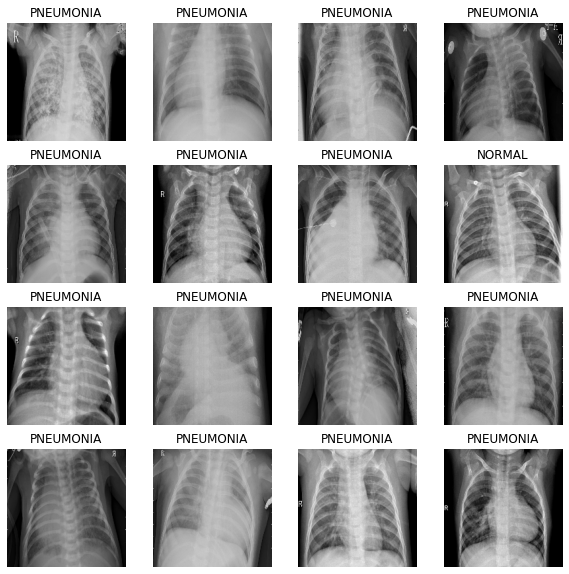

In [16]:
image_batch, label_batch = next(iter(augmented_train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

**4-3. Preview of _non-augmented_ training image data samples**

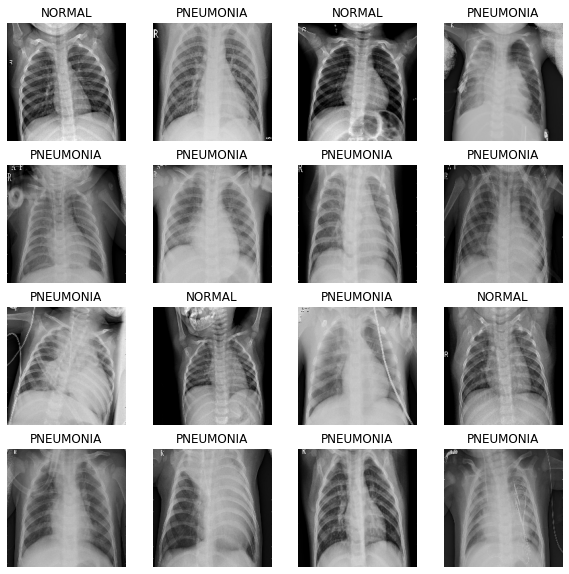

In [17]:
image_batch, label_batch = next(iter(original_train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

✏️ 폐의 모양이 대칭 구조를 가지고 있으며, 폐렴 현상 또한 좌우 상관없이 임의의 위치에서 나타나므로, 육안상으로는 좌우 반전에 의한 augmentation 효과를 확인하기 어렵다 

---
## 🩻 Construct CNN model

### 1. Implement convolution block

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

### 2. Implement dense block

In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

### 3. Build CNN model with blocks

In [22]:
def cnn_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [23]:
# check the CNN model structure
model = cnn_model()
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)      

---
## 🩻 Construct ResNet-18 model
💡 [Implementing ResNet-18 Using Keras](https://www.kaggle.com/code/songrise/implementing-resnet-18-using-keras) 해당 사이트 참조하여 구현

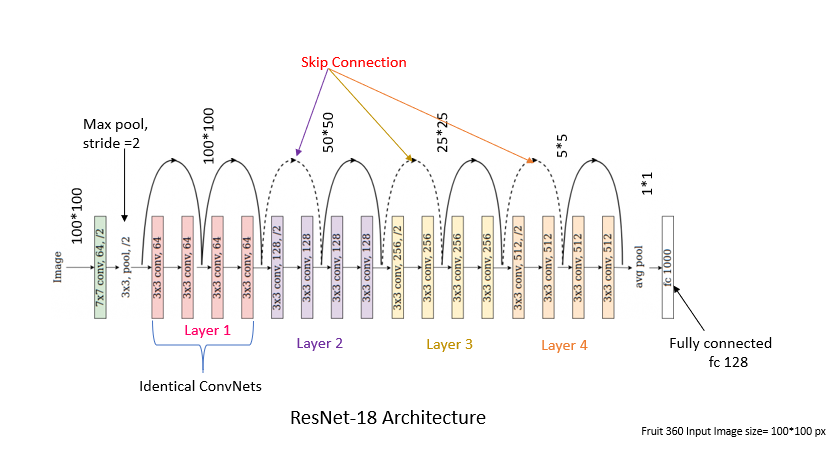

### 1. Define basic resnet block (residual block)

In [24]:
def resnet_block(inputs, channels, down_sample=False):
    """
    A standard resnet block.

    Args:
        inputs: Input tensor.
        channels (int): Number of channels (number of convolution kernels).
        down_sample (bool): Whether to perform down sampling.

    Returns:
        tf.Tensor: Output tensor.
    """
    strides = [2, 1] if down_sample else [1, 1]
    KERNEL_SIZE = (3, 3)
    INIT_SCHEME = "he_normal"

    # First convolution layer
    x = tf.keras.layers.Conv2D(channels, strides=strides[0], kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.nn.relu(x)

    # Second convolution layer
    x = tf.keras.layers.Conv2D(channels, strides=strides[1], kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Shortcut connection
    if down_sample:
        res = tf.keras.layers.Conv2D(channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")(inputs)
        res = tf.keras.layers.BatchNormalization()(res)
    else:
        res = inputs

    # Resize shortcut connection if needed
    if res.shape[-1] != x.shape[-1]:
        res = tf.keras.layers.Conv2D(x.shape[-1], kernel_size=(1, 1), strides=strides[0], padding="same", kernel_initializer=INIT_SCHEME)(res)
        res = tf.keras.layers.BatchNormalization()(res)

    # Merge with shortcut connection
    x = tf.keras.layers.add([x, res])
    out = tf.nn.relu(x)
    return out

### 2. Build ResNet 18 with blocks

In [25]:
def resnet_model(input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)):
    """
    Builds a binary classification ResNet-18 model.

    Args:
        input_size (tuple): Shape of the input tensor (height, width, channels).

    Returns:
        tf.keras.Model: Binary classification ResNet-18 model.
    """
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(64, (7, 7), strides=2, padding="same", kernel_initializer="he_normal")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.nn.relu(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding="same")(x)

    # Building ResNet blocks
    for channels in [64, 128, 256, 512]:
        x = resnet_block(x, channels)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.models.Model(inputs, x)
    return model

In [26]:
# check the CNN model structure
model = resnet_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 90, 90, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 90, 90, 64)   256         conv2d_2[0][0]                   
__________________________________________________________________________________________________
tf.nn.relu (TFOpLambda)         (None, 90, 90, 64)   0           batch_normalization_7[0][0]      
______________________________________________________________________________________________

---
## 🩻 Prepare experiments

### 1. Set weights to settle data imbalance
💡 PNEUMONIA 데이터 갯수가 NORMAL 데이터 갯수에 비해 훨씬 비중이 높으므로, 가중치를 부여하여 데이터 불균형을 제어

In [27]:
# the number of NORMAL/PNEUMONIA within training data
TRAIN_NRM_IMG_CNT = len([filename for filename in train_filenames if "NORMAL" in filename])
TRAIN_PNM_IMG_CNT = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

# set loss weight for data imbalance (0 = False = NORMAL / 1 = True = PNEUMONIA)
weight_for_0 = (1 / TRAIN_NRM_IMG_CNT) * (TRAIN_IMG_CNT) / 2.0 
weight_for_1 = (1 / TRAIN_PNM_IMG_CNT) * (TRAIN_IMG_CNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}



# check weight values
print("Weight values are all set for NORMAL/PNEUMONIA data imbalance!")
print_single_divider()
print(">>> weight for NORMAL    : ", weight_for_0)
print(">>> weight for PNEUMONIA : ", weight_for_1)

Weight values are all set for NORMAL/PNEUMONIA data imbalance!
--------------------------------------------------------------------------------
>>> weight for NORMAL    :  1.955607476635514
>>> weight for PNEUMONIA :  0.6717495987158908


### 2. Define training methods with different options
💡 vanilla CNN 및 ResNet 모델, augmentation 처리 여부, data imbalance 문제를 위한 weight 처리 여부 등 다양한 상황에 따라 실험을 수행할 수 있도록 실험 수행 함수 정의

In [28]:
def train_model(model_type, train_dataset, val_dataset, imbalance = True):
    
    # get ready with training model
    with tf.device('/GPU:0'):
        # get training model
        model = None 
        if model_type == CNN:
            model = cnn_model()
        elif model_type == RESNET:
            model = resnet_model()

        # define training metrics
        METRICS = [
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]

        # compile training model
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=METRICS
        )
    
    
    
    # training by data imbalance weight options
    if imbalance == True:
        with tf.device('/GPU:0'):
            history = model.fit(
            train_dataset,
            steps_per_epoch=TRAIN_IMG_CNT // BATCH_SIZE,
            epochs=EPOCHS,
            validation_data= val_dataset,
            validation_steps=VAL_IMG_CNT // BATCH_SIZE,
            class_weight=class_weight,
        )
        
    else:    # class_weight == False:
        with tf.device('/GPU:0'):
            history = model.fit(
            train_dataset,
            steps_per_epoch=TRAIN_IMG_CNT // BATCH_SIZE,
            epochs=EPOCHS,
            validation_data= val_dataset,
            validation_steps=VAL_IMG_CNT // BATCH_SIZE,
        )
    
    print_single_divider()
    print("Model training successfully finished!")        
    return model, history

### 3. Define training result display method

In [29]:
def display_result(model, history):
    # print accuracies
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print_single_divider()
    print(">>> loss      : ", loss)
    print(">>> accuracy  : ", accuracy)
    print(">>> precision : ", precision)
    print(">>> recall    : ", recall)
    
    
    # display visual plots
    fig, ax = plt.subplots(1, 4, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
        ax[i].plot(history.history[met], color='lightpink')
        ax[i].plot(history.history['val_' + met], color='hotpink')
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
    
    print_single_divider()
    plt.show()

---
## 🩻 Experimental Results

### 1. Experiments with CNN model

**1-1. Adjust hyper-parameters**

In [30]:
BATCH_SIZE = 64
EPOCHS = 20

**1-2. Experiment with _augmented data_ & imbalance wieghts**

In [31]:
model, history = train_model(model_type = CNN,
                             train_dataset = augmented_train_ds,
                             val_dataset = augmented_val_ds,
                             imbalance = True)

Epoch 1/20
65/65 [==============================] - 32s 290ms/step - loss: 0.6798 - accuracy: 0.6462 - precision: 0.8745 - recall: 0.6081 - val_loss: 0.6214 - val_accuracy: 0.7227 - val_precision: 0.7227 - val_recall: 1.0000
Epoch 2/20
65/65 [==============================] - 19s 298ms/step - loss: 0.4167 - accuracy: 0.7990 - precision: 0.9509 - recall: 0.7712 - val_loss: 0.5613 - val_accuracy: 0.7539 - val_precision: 0.7539 - val_recall: 1.0000
Epoch 3/20
65/65 [==============================] - 19s 297ms/step - loss: 0.3532 - accuracy: 0.8673 - precision: 0.9663 - recall: 0.8514 - val_loss: 0.6809 - val_accuracy: 0.7031 - val_precision: 0.7031 - val_recall: 1.0000
Epoch 4/20
65/65 [==============================] - 19s 300ms/step - loss: 0.2801 - accuracy: 0.8856 - precision: 0.9740 - recall: 0.8698 - val_loss: 0.6966 - val_accuracy: 0.7148 - val_precision: 0.7148 - val_recall: 1.0000
Epoch 5/20
65/65 [==============================] - 21s 327ms/step - loss: 0.2734 - accuracy: 0.9010

39/39 [==============================] - 4s 107ms/step - loss: 0.6923 - accuracy: 0.7356 - precision: 0.7034 - recall: 0.9974
--------------------------------------------------------------------------------
>>> loss      :  0.6923463940620422
>>> accuracy  :  0.7355769276618958
>>> precision :  0.7034357786178589
>>> recall    :  0.9974358677864075
--------------------------------------------------------------------------------


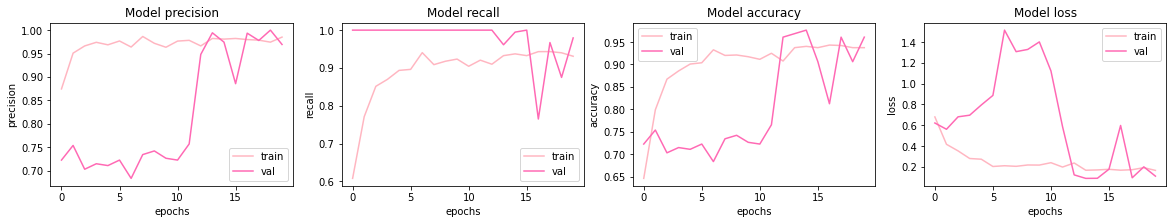

In [32]:
display_result(model, history)

**1-3. Experiment with _augmented data_**

In [33]:
model, history = train_model(model_type = CNN,
                             train_dataset = augmented_train_ds,
                             val_dataset = augmented_val_ds,
                             imbalance = False)

Epoch 1/20
65/65 [==============================] - 29s 301ms/step - loss: 0.6587 - accuracy: 0.6760 - precision: 0.8699 - recall: 0.6606 - val_loss: 0.6622 - val_accuracy: 0.7422 - val_precision: 0.7422 - val_recall: 1.0000
Epoch 2/20
65/65 [==============================] - 19s 297ms/step - loss: 0.3942 - accuracy: 0.8269 - precision: 0.9355 - recall: 0.8243 - val_loss: 0.5581 - val_accuracy: 0.7539 - val_precision: 0.7539 - val_recall: 1.0000
Epoch 3/20
65/65 [==============================] - 19s 291ms/step - loss: 0.3318 - accuracy: 0.8692 - precision: 0.9461 - recall: 0.8758 - val_loss: 0.6414 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 4/20
65/65 [==============================] - 19s 294ms/step - loss: 0.2365 - accuracy: 0.9087 - precision: 0.9519 - recall: 0.9236 - val_loss: 0.7488 - val_accuracy: 0.7305 - val_precision: 0.7305 - val_recall: 1.0000
Epoch 5/20
65/65 [==============================] - 20s 313ms/step - loss: 0.2097 - accuracy: 0.9240

39/39 [==============================] - 5s 115ms/step - loss: 1.9333 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
--------------------------------------------------------------------------------
>>> loss      :  1.933349609375
>>> accuracy  :  0.625
>>> precision :  0.625
>>> recall    :  1.0
--------------------------------------------------------------------------------


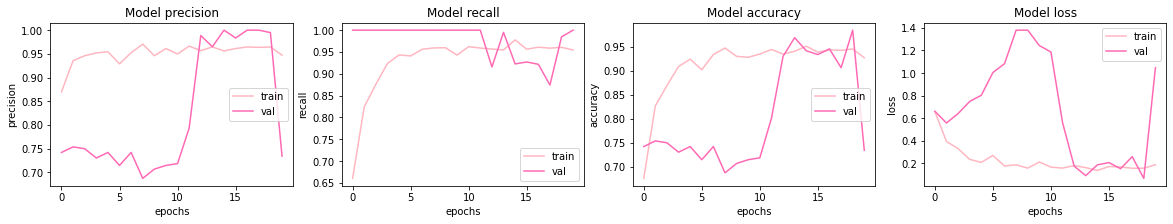

In [34]:
display_result(model, history)

**1-4. Experiment with _non-augmented data_ & imbalance wieghts**

In [35]:
model, history = train_model(model_type = CNN,
                             train_dataset = original_train_ds,
                             val_dataset = original_val_ds,
                             imbalance = True)

Epoch 1/20
65/65 [==============================] - 29s 306ms/step - loss: 0.6547 - accuracy: 0.6471 - precision: 0.8781 - recall: 0.6034 - val_loss: 0.7088 - val_accuracy: 0.2422 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
65/65 [==============================] - 19s 290ms/step - loss: 0.3883 - accuracy: 0.8010 - precision: 0.9612 - recall: 0.7648 - val_loss: 0.5893 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/20
65/65 [==============================] - 19s 288ms/step - loss: 0.3220 - accuracy: 0.8558 - precision: 0.9724 - recall: 0.8275 - val_loss: 0.5338 - val_accuracy: 0.7773 - val_precision: 0.7773 - val_recall: 1.0000
Epoch 4/20
65/65 [==============================] - 19s 298ms/step - loss: 0.3005 - accuracy: 0.8702 - precision: 0.9767 - recall: 0.8494 - val_loss: 0.7885 - val_accuracy: 0.6836 - val_precision: 0.6836 - val_recall: 1.0000
Epoch 5/20
65/65 [==============================] - 20s 307ms/step - loss: 0.2499 - accuracy

39/39 [==============================] - 4s 110ms/step - loss: 1.0312 - accuracy: 0.6923 - precision: 0.6701 - recall: 1.0000
--------------------------------------------------------------------------------
>>> loss      :  1.0312129259109497
>>> accuracy  :  0.692307710647583
>>> precision :  0.6701030731201172
>>> recall    :  1.0
--------------------------------------------------------------------------------


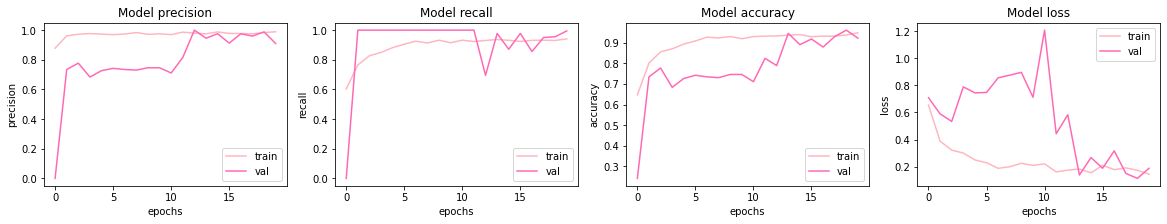

In [36]:
display_result(model, history)

✏️ **CNN 모델 실험 분석**
- data augmentation, data imbalance weight 에 대하여 ablation test를 수행하였다. (EPOCHS = 20, BATCH_SIZE = 64)  
- data augmentation, imbalance weight를 모두 적용하였을 경우, accuracy 약 0.74 및 precision 0.70 정도로 (낮은 EPOCHS 수치를 감안했을 때) 무난한 수준의 성능을 보이는 듯 하였으나...! recall 약 1.00에 달하는 수치를 달성하면서, 어쩌면 우연에 의한 성능일 가능성을 열어두었다.   
- imbalance wieght를 적용하지 않을 경우 recall를 제외한 모든 metrics 의 평가가 낮게 평가되는 것을 확인할 수 있었다.
- data augmentation을 적용하지 않았을 경우, 적용한 경우 대비 성능이 약간 저하되었으나 그 수치가 적은 편으로 augmentation의 효과를 판단하기 어려웠다.

### 2. Experiments with ResNet-18 model

**2-1. Adjust hyper-parameters**

In [37]:
EPOCHS = 20
BATCH_SIZE = 64

**2-2. Experiment with _augmented data_ & imbalance wieghts**

In [38]:
model, history = train_model(model_type = RESNET,
                             train_dataset = augmented_train_ds,
                             val_dataset = augmented_val_ds,
                             imbalance = True)

Epoch 1/20
65/65 [==============================] - 33s 311ms/step - loss: 0.4298 - accuracy: 0.8250 - precision: 0.9382 - recall: 0.8201 - val_loss: 40.9072 - val_accuracy: 0.2891 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
65/65 [==============================] - 20s 308ms/step - loss: 0.2619 - accuracy: 0.8923 - precision: 0.9598 - recall: 0.8930 - val_loss: 6.2504 - val_accuracy: 0.7383 - val_precision: 0.7383 - val_recall: 1.0000
Epoch 3/20
65/65 [==============================] - 19s 299ms/step - loss: 0.2444 - accuracy: 0.9038 - precision: 0.9705 - recall: 0.8973 - val_loss: 2.0366 - val_accuracy: 0.7812 - val_precision: 0.7812 - val_recall: 1.0000
Epoch 4/20
65/65 [==============================] - 20s 311ms/step - loss: 0.2353 - accuracy: 0.9173 - precision: 0.9712 - recall: 0.9160 - val_loss: 19.8987 - val_accuracy: 0.2578 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
65/65 [==============================] - 20s 305ms/step - loss: 0.2246 

39/39 [==============================] - 5s 114ms/step - loss: 0.8747 - accuracy: 0.6154 - precision: 0.8989 - recall: 0.4333
--------------------------------------------------------------------------------
>>> loss      :  0.8747330904006958
>>> accuracy  :  0.6153846383094788
>>> precision :  0.8989361524581909
>>> recall    :  0.4333333373069763
--------------------------------------------------------------------------------


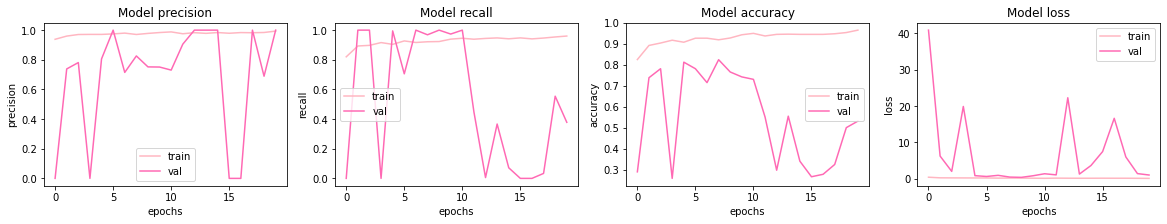

In [39]:
display_result(model, history)

**2-3. Experiment with _augmented data_**

In [40]:
model, history = train_model(model_type = CNN,
                             train_dataset = augmented_train_ds,
                             val_dataset = augmented_val_ds,
                             imbalance = False)

Epoch 1/20
65/65 [==============================] - 28s 294ms/step - loss: 0.7123 - accuracy: 0.6394 - precision: 0.8576 - recall: 0.6277 - val_loss: 0.6367 - val_accuracy: 0.7617 - val_precision: 0.7617 - val_recall: 1.0000
Epoch 2/20
65/65 [==============================] - 19s 297ms/step - loss: 0.4715 - accuracy: 0.7837 - precision: 0.9072 - recall: 0.7918 - val_loss: 0.5882 - val_accuracy: 0.7266 - val_precision: 0.7266 - val_recall: 1.0000
Epoch 3/20
65/65 [==============================] - 18s 283ms/step - loss: 0.3231 - accuracy: 0.8606 - precision: 0.9338 - recall: 0.8747 - val_loss: 0.6599 - val_accuracy: 0.7266 - val_precision: 0.7266 - val_recall: 1.0000
Epoch 4/20
65/65 [==============================] - 19s 297ms/step - loss: 0.2462 - accuracy: 0.9173 - precision: 0.9478 - recall: 0.9377 - val_loss: 0.7544 - val_accuracy: 0.7422 - val_precision: 0.7422 - val_recall: 1.0000
Epoch 5/20
65/65 [==============================] - 20s 314ms/step - loss: 0.2491 - accuracy: 0.9058

39/39 [==============================] - 5s 116ms/step - loss: 0.7926 - accuracy: 0.7420 - precision: 0.7093 - recall: 0.9949
--------------------------------------------------------------------------------
>>> loss      :  0.7925735712051392
>>> accuracy  :  0.7419871687889099
>>> precision :  0.7093235850334167
>>> recall    :  0.9948717951774597
--------------------------------------------------------------------------------


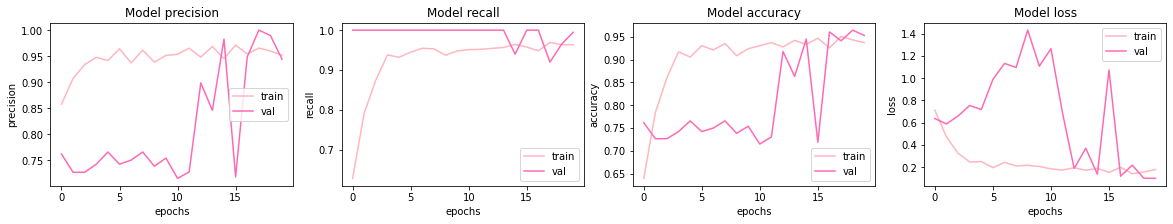

In [41]:
display_result(model, history)

**2-4. Experiment with _non-augmented data_ & imbalance wieghts**

In [42]:
model, history = train_model(model_type = RESNET,
                             train_dataset = original_train_ds,
                             val_dataset = original_val_ds,
                             imbalance = True)

Epoch 1/20
65/65 [==============================] - 29s 313ms/step - loss: 0.4420 - accuracy: 0.8240 - precision: 0.9288 - recall: 0.8306 - val_loss: 1.5734 - val_accuracy: 0.6641 - val_precision: 0.7325 - val_recall: 0.8698
Epoch 2/20
65/65 [==============================] - 19s 302ms/step - loss: 0.2170 - accuracy: 0.9202 - precision: 0.9777 - recall: 0.9129 - val_loss: 2.9282 - val_accuracy: 0.7188 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 3/20
65/65 [==============================] - 19s 296ms/step - loss: 0.2159 - accuracy: 0.9029 - precision: 0.9649 - recall: 0.9051 - val_loss: 4.4592 - val_accuracy: 0.7266 - val_precision: 0.7266 - val_recall: 1.0000
Epoch 4/20
65/65 [==============================] - 19s 299ms/step - loss: 0.2289 - accuracy: 0.9173 - precision: 0.9702 - recall: 0.9132 - val_loss: 1.0950 - val_accuracy: 0.7695 - val_precision: 0.7659 - val_recall: 1.0000
Epoch 5/20
65/65 [==============================] - 19s 298ms/step - loss: 0.1833 - accuracy: 0.9279

39/39 [==============================] - 5s 123ms/step - loss: 4.5408 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
--------------------------------------------------------------------------------
>>> loss      :  4.540829181671143
>>> accuracy  :  0.625
>>> precision :  0.625
>>> recall    :  1.0
--------------------------------------------------------------------------------


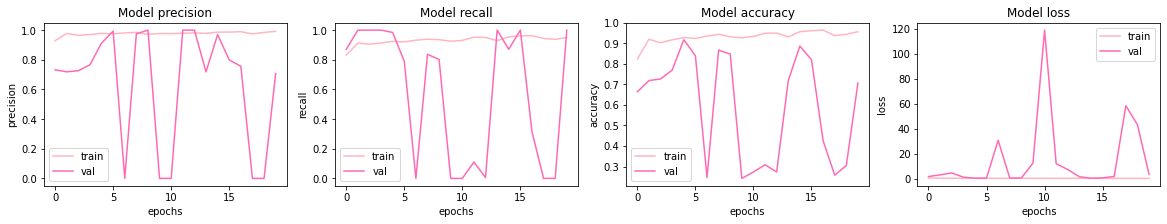

In [43]:
display_result(model, history)

✏️ **ResNet-18 모델 실험 분석**
- data augmentation, data imbalance weight 에 대하여 ablation test를 수행하였다. (EPOCHS = 20, BATCH_SIZE = 64)  
- data augmentation, imbalance weight를 모두 적용하였을 경우, accuracy 약 0.62 및 precision 0.90 정도를 달성하였다. 단 CNN 모델과 달리 recall 약 0.43의 수치를 달성하면서, 어느 정도 이진 분류를 시도하고 있다는 생각이 들었다.
- imbalance wieght를 적용하지 않을 경우 precision을 제외한 모든 성능 평가 기준이 상향된 것을 확인할 수 있었다. CNN 모델과 비교했을 때 imbalacne weight의 효과를 무조건 긍정으로 판단하기는 어렵다.
- data augmentation을 적용하지 않았을 경우, 전반적으로 학습 성능이 대폭 하향되었다. 단, 시각화 그래프가 크게 요동치는 것으로 보았을 때 data augmentation의 효과가 무조건 부정적이라기 보다는 우연에 의한 하향일 가능성이 있다.

### 3. Evaluation

- CNN 및 ResNet-18 모델을 실험한 결과 (EPOCHS = 20, BATCH_SIZE = 64), 각각 loss, accuracy, precision, recall 이 서로 반대의 양상을 띄었으므로, 단순 학습 목적에서는 어느 모델이 더욱 나은 모델인지 판단하기 어려웠다. 단, 의료 분야 특성을 고려했을 때에는 더욱 의미있는 평가 기준에 따라 학습 모델을 선택할 수 있을 것이다.
- CNN 모델의 경우, imbalance weight를 적용하지 않았을 때 전반적인 학습 성능이 크게 저하하였는데, 이로써 균형잡힌 데이터 사전 확보와 부득이한 경우의 imbalance weight 적용의 중요성을 확인할 수 있었다. 단, ResNet-18 모델의 경우 imbalance weight의 효과를 판단하기 어려운 경향이 있다.
- data augmentation의 경우 두 모델에 상관없이 그 효과를 판단하기가 애매한 수치를 보였다.  
  폐는 대칭 형태의 모양을 갖고 있고, 폐렴 또한 좌우 위치에 상관없이 임의로 발생하므로 이론상으로 좌우반전의 augmentation의 효과를 기대하기 어렵다고 판단한다.
  특히 가슴 부분의 심장으로 인해 인체에 비대칭 효과가 발생하기도 하므로, 데이터 수집이 어렵다고 해서 섣불리 augmentation을 하는 것은 위험할 수 있다.  
- 두 학습 모델 모두 학습 수행 시 성능 값에 대한 시각화 그래프가 요동치는 모양을 보이고 점을 고려했을 때, 주어진 학습 데이터 및 실험 환경만으로는 아무래도 높은 학습 성능을 기대하기 어렵거나, 성능이 높더라도 우연에 의한 가능성이 높을 것이다.

---
## 📝 Research note

**[연구요약]**  
이미지 데이터 학습을 통해 이진 분류(폐렴 여부)를 수행하는 심층 학습을 구현 및 실험하였다.  
모델 구현 과정에서 CNN 및 ResNet-18에 관한 구조를 보다 깊이 이해할 수 있었다.  
또한 각종 데이터 전처리와 hyper-parameter, 모델 학습 환경 설정에 따른 ablation을 수행하면서, 모델 설계 이외의 과정 또한 얼마나 중요한 것인지 체감할 수 있었다.

**[느 낀 점]**  
의료는 사람에게 치명적이나, 개인마다 의료 부담이 크게 다가오는 경우도 많을 것이다.  
의료 분야에 AI가 적용되면 이러한 문제가 해소될 것으로 기대할 수 있지만, 기술적으로 결코 쉽게 달성하기는 어려울 것이다.  
이전에 의료 지망생들을 위한 가상 수술 simulation 프레임워크를 연구한 적이 있는데, 큰 책임감이 있는만큼 연구가 결코 쉽지 않음을 느낄 수 있었다.  
그럼에도 불구하고 항상 용기를 내어 노력으로 발전을 꾀하는 연구자들, 개발자들은 그 도전만으로도 훌륭한 것 같다.

---
## 📝 References

- _**ResNet 모델 구조의 제안과 효과**_  
  - HE, Kaiming, et al. Deep residual learning for image recognition. In: Proceedings of the IEEE conference on computer vision and pattern recognition. 2016. p. 770-778.  
  - HE, Kaiming, et al. Delving deep into rectifiers: Surpassing human-level performance on imagenet classification. In: Proceedings of the IEEE international conference on computer vision. 2015. p. 1026-1034.
- _**tensorflow.keras를 이용한 ResNet-18 구현 아이디어 참조**_
  - [Implementing ResNet-18 Using Keras](https://www.kaggle.com/code/songrise/implementing-resnet-18-using-keras)
- _**normalization layer와 dropout layer를 동시에 사용하는 것에 대한 긍정적 재고**_  
  - CHEN, Guangyong, et al. Rethinking the usage of batch normalization and dropout in the training of deep neural networks. arXiv preprint arXiv:1905.05928, 2019.
- _**의료 분야에서 ResNet 활용 방안 제시**_  
  - AYYACHAMY, Swarnambiga, et al. Medical image retrieval using Resnet-18. In: Medical imaging 2019: imaging informatics for healthcare, research, and applications. SPIE, 2019. p. 233-241.